# CPSC 4970 AI + ML: Module 6 -- combining SOM with MLP

[sklearn-som documentation](https://pypi.org/project/sklearn-som/)

In [1]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn_som.som import SOM
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

# Fit 5x5 SOM to Iris data set

In [2]:
df = load_iris(as_frame=True)['frame']
print(df.shape)
print(df.columns)

(150, 5)
Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)', 'target'],
      dtype='object')


In [3]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 0:-1], df['target'])

In [4]:
som = SOM(m=5, n=5, dim=df.shape[1]-1)
som.fit(X_train.values)
print(som.predict(X_train.values))

[ 5 16  9 10 14  6  5 12 12 17  6 16  5  9 14 10 19  9  6 15  9 14 22 14
  9 17 14 17  9 21 22  9 14 19 10 16  0 12 14  9 10  9  6  9 10 10 14 10
 19 21 10 22 22  6  9 10 14 15  6 22 19 10 17 14  5  9 12 14  6 14 21  5
 21 14 22 20 17 10 12  0  0  0 12 21 19 12  2 10 15 20  6  0 20 11 14 12
 14 22 16  2 23 14  6 17 15  9  9 16  9  9 14  1]


In [5]:
aug_X_train = np.append(X_train, som.predict(X_train.values).reshape(-1, 1), axis=1)
print(X_train.shape)
print(aug_X_train.shape)
aug_X_test = np.append(X_test, som.predict(X_test.values).reshape(-1, 1), axis=1)
print(X_test.shape)
print(aug_X_test.shape)

pipeline = Pipeline(
    [('preproc', make_column_transformer(
        (OneHotEncoder(handle_unknown='ignore'), [aug_X_train.shape[1]-1]),
        (StandardScaler(), slice(0, aug_X_train.shape[1]-1)))),
     ('classifier', MLPClassifier(max_iter=2000))]
)

cv_params = {
    'classifier__hidden_layer_sizes': [(10, ), (20, ), (40, ), (80, ),
                                       (10, 5), (20, 10), (40, 20), (80, 40)],
    'classifier__alpha': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.4]
}

cv = GridSearchCV(pipeline, cv_params, n_jobs=-1)
cv.fit(aug_X_train, y_train)
print("Training accuracy:", accuracy_score(y_train, cv.predict(aug_X_train)))
print("Testing accuracy:", accuracy_score(y_test, cv.predict(aug_X_test)))

(112, 4)
(112, 5)
(38, 4)
(38, 5)


/Users/shaffer/Courses/CPSC4973ArtificialIntelligence/Code/Live/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Training accuracy: 0.9910714285714286
Testing accuracy: 0.9473684210526315


{'classifier__alpha': 0.01, 'classifier__hidden_layer_sizes': (20,)}


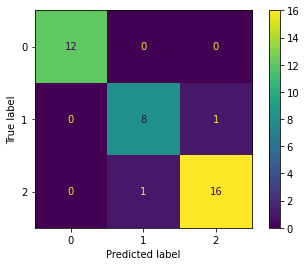

In [9]:
from sklearn.metrics import plot_confusion_matrix
print(cv.best_params_)
plot_confusion_matrix(cv, aug_X_test, y_test)